# Computer Vision Notebook

Se pide la elaboración de una memoria M0 en donde se recogan los procedimientos realizados y resultados obtenidos del procesado de una serie de imágenes del cerebro. Se trata de distinguir el lóbulo temporal en imágenes 2D hasta que éste se une a la parte central del cerebro.

Imagenes disponibles:
    * I3T : Imagen de Resonancia Magnética de 3T
    * I3TGM : Voxel de materia gris
    * I3TWM : Voxel de materia blanca
    * I3TCSF : Voxel de líquido cerebroespinal

Se deben abordar los siguientes pasos:

1 .- Leer las imágenes 3D y obtener las imágenes 2D correspondientes a cada corte del plano coronal.  
2 .- Localizar blobs en 2D  
3 .- Identificar objetos en 2D  
    * Objeto tipo 1: Blob de GM aislado - Se produce cuando comienza a aparecer el lóbulo temporal
    * Objeto tipo 2: Blob de GM aislado que contiene blob de WM
    * Objeto tipo 3: División de blobs grandes en puntos de corte más probables. Localización del lóbulo temporal.
4 .- Localizar en la GM los giros y los surcos
    * Puntos de máxima curvatura interior y exterior de la GM
    * Unir los puntos para distinguir los giros y los surcos.

Este notebook es complementario a la memoria M0 y alberga las configuraciones, pasos y comprobaciones realizadas, permitiendo al lector reproducirlas y modificarlas para la mejor comprensión de los procedimientos.

## Entorno de trabajo
Sistema operativo: Ubuntu 16.04  
Lenguaje escogido: Python  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Dada la falta de experiencia en programación del autor, se ha decidido utilizar un mismo lenguaje para las tareas de las distintas asignaturas. Se ha escogido Python por haber hecho ya anteriormente la apuesta por conocer este entorno en las asignaturas paralelas y se respalda esta decisión en la creciente utilización de este lenguaje, en particular en la visión por ordenador.  
    
Librerías utilizadas:  
    * Scipy - Ecosistema open-source basado en Python para operaciones matemáticas. Contiene los paquetes scipy-library, numpy, matplotlib, ipython, simpy, pandas
    * Numpy - Librería básica para el tratamiento de arrays
    * Matplotlib - Librería básica para la visualización de imágenes y gráficos.
    * Ipython - Para la utilización de los notebooks Jupyter.
    * ITK - Se ha realizado un 'wraping' o 'envoltura' de la librería original (c++) para poder ser utilizada mediante Python
    * SimpleITK - Proporciona la mayoría de las funciones propias de ITK pero con un mayor nivel de abstracción, reduciendo los procedimientos necesarios. 
    * Scikit-image - Proporciona gran cantidad de funciones y filtros de tratamiento de imágenes, tiene alta compatibilidad con las librerías matplotlib y numpy

Software utilizado:
    * Python     - Para la elaboración del programa final
    * Ipython    - Para la realización de pruebas
    * Jupyter Notebook  - Para la exposición de resultados y realización de pruebas
    * 3dSlicer v4.8.1   - Para la obtención de imágenes 2D
    * Fiji (Fiji Is Just ImageJ) - Para la visualización de imágenes instanciadas por la órden Show de la librería SimpleITK


## Procedimiento

### 1 - Leer las imágenes 3D y obtener las imágenes 2D correspondientes a cada corte del plano coronal.

Para este procedimiento se ha utilizado el software 3dSlicer, recomendado por la comunidad de SimpleITK y posteriormente se ha hecho un tratamiento sobre imágenes Dicom para obtener los slices en formato PNG.

#### 1.1 - Obtención de los slices de 2D

1 .- Abrir el programa
    * Abrir el terminal (CTRL + ALT + T)
    * Localizar el ejecutable del programa 3dslice en el disco y ejecutar './path/to/file/Slicer'
    
2 .- Carga de datos: 
    * En el menu 'File' seleccionar 'Add data' > 'Choose File(s) to Add'
    * Localizar fichero en el disco '/path/to/file/I3TWM.hdr' y presionar 'Open'

Para obtener los slices individuales se hace uso del módulo 'Create a DICOM Series'. Sin embargo, este método, proporciona las imágenes segmentadas acorde al plano axial, mientras el problema requiere obtener las del plano coronal. Para lograr obtener las secciones adecuadas se debe cambiar la orientación del modelo, lo que se realiza con el módulo 'Orient Scalar Volume'

3 .- Rotación del modelo ([modulo_info](https://www.slicer.org/wiki/Modules:OrientImages-Documentation-3.6)): 
    * En el desplegable de 'Modules' escoger 'Converters' > 'Orient Scalar Volume'
    * En el apartado 'IO' > desplegable 'Input Volume 1' escoger 'I3TWM'
    * En el apartado 'IO' > desplegable 'Output Volume' escoger 'I3TWM'
    * En el apartado 'Orientation Parameters' escoger la orientación 'Coronal' y presionar 'Apply'.
    
4 .- Obtención de los slices: 
    * En el desplegable de 'Modules' escoger 'Converters' > 'Create a DICOM Series'
    * En el apartado 'Input' > desplegable 'Input Volume' escoger 'I3TWM'
    * En el apartado 'Filter Settings' > opción 'DICOM Directory' > seleccionar directorio de destino
    * En el apartado 'Filter Settings' > opción 'Output Type:' > Seleccionar 'unsigned short' para posteriormente convertir las imágenes a formato '.png' y presionar 'Apply'
Las imágenes DICOM se caracterizan por incluir una capa de meta-datos que habitualmente aloja la información del paciente. Para obtener las imágenes se descarta dicha información, a parte de no ser necesaria, si es información real, no se debe publicar.

    
    


In [ ]:
Se deben repetir los pasos 2, 3 y 4 con los ficheros I3TGM, I3TCSF e I3T

Llegado a este punto se tienen tantos slices como el valor de la tercera dimensión en la imagen, en función del giro aplicado al modelo la tercera dimensión será más o menos larga (la imagen 3D no es un cubo regular).

#### 1.2 - Conversión de slices de formato DICOM a formato PNG

Será necesaria la conversión de las imágenes a un formato exclusivo de imagen como PNG, ya que los datos clínicos no son relevantes para este estudio y el trabajo con numpy-arrays es altamente recomendado y extendido. Por ello, se define una estructura de ficheros donde organizar los datos.

In [ ]:
!tree -L 3

##### 1.2.1 - Configuración del entorno para visualización de imágenes mediante la librería SimpleITK

Para la extracción y la visualización de las imágenes se utilizan órdenes de la librería **SimpleITK**. Concretamente, el comando **Show** busca por defecto el ejecutable del programa ImageJ, siendo necesaria la adecuada configuración del entorno para la utilización de otro visualizador.

Se dispone de un pequeño script en Python para la visualización y conversión de las imágenes Dicom mediante funciones de la librería SimpleITK. Este programa recibe como argumentos el directorio de los archivos Dicom y el fichero saliente deseado. La ejecución a priori de este script resulta en el siguiente error:

En este caso se ha instalado la versión más actual de ImageJ: Fiji (Fiji Is Just ImageJ) / ImageJ2. El nombre del ejecutable del programa no es el mismo que tiene almacenado por defecto la configuración de SimpleITK por lo que es necesario indicarle al entorno de la librería dónde puede encontrar el ejecutable para visualizar las imágenes.

Se puede indicar cualquier programa válido; se va a mantener la recomendación de utilizar Fiji y para ello se debe actualizar la variable de entorno SITK_SHOW_COMMAND. Su valor viene preestablecido internamente, por lo que una exploración del entorno no muestra dicha variable a no ser que haya sido explícitamente establecida:

In [277]:
!env | grep -e SITK

SITK_SHOW_COMMAND=/home/jetxeberria/Documents/Programs/fiji/Fiji.app/ImageJ-linux64


Para ejecutar órdenes propias del shell se utiliza el comando 'mágico' de Ipython **%system**, al cual se puede acceder mediante el atajo (!!) precediento a la orden deseada, reportando el output en formato de lista. El atajo (!) reporta el mismo resultado pero como un único string. Con este método ejecutamos las órdenes de shell desde este mismo espacio de trabajo.

La ejecución del Jupyter Notebook, se realiza desde un proceso de *bash* con un determinado entorno, por lo que con una inicialización limpia del programa, la órden previa no debería devolver nada. Si se ha actualizado el entorno anteriormente, se obtendrán los comandos correspondientes.

La interacción con el entorno de bash no es posible mediante la utilización de las órdenes de bash típicas precedidas de (!). Por lo que los pasos siguientes se deben realizar de forma preliminar en el mismo entorno que inicie el notebook.

Se define explícitamente la variable de entorno SITK_SHOW_COMMAND.  

Se debe exportar esta variable cada vez que se abra un nuevo entorno de trabajo (*proceso shell*) y se desee hacer uso de la orden **Show** de SimpleITK. Presumiblemente se va a continuar utilizando esta función en los días de trabajo próximos, por lo que se añade la orden de exportación al final del fichero de inicialización del terminal, **.bashrc**.

Ya sea editándolo directamente:

O enviando el string al final del fichero:  

El archivo .bashrc se carga cada vez que se ejecuta un nuevo proceso *bash*. En caso de no haber exportado previamente las variables y haber expandido directamente el archivo .bashrc, es necesario actualizar el entorno del proceso *bash*.

Se verifica la actualización del entorno:  

Llegado a este punto se debe ejecutar nuevamente el notebook. Para realizar esto teniendo acceso a los ficheros del directorio raiz, acudir al mismo y ejecutar jupyter en dicha ruta.

Al ejecutarse el notebook se guarda una copia del estado del entorno y de ahí en adelante los cambios que se realicen son exclusivos del entorno del notebook. 

In [278]:
%set_env SITK_SHOW_COMMAND='/home/jetxeberria/Documents/Programs/fiji/Fiji.app/ImageJ-linux64'

env: SITK_SHOW_COMMAND='/home/jetxeberria/Documents/Programs/fiji/Fiji.app/ImageJ-linux64'


In [279]:
!env | grep -e SITK

SITK_SHOW_COMMAND='/home/jetxeberria/Documents/Programs/fiji/Fiji.app/ImageJ-linux64'


A pesar de este resultado, el entorno de trabajo original (el del proceso *bash*) sigue siendo el mismo, y así se puede comprobar:

Si no se habían establecido previamente las variables de entorno, no aparecerán, los cambios del entorno del notebook no se transmiten al entorno del proceso padre. 

Es necesario actualizar el entorno en dicho proceso, ya que la ejecución del programa de visualización Fiji es gestionada desde el proceso padre y es éste quien debe tener sus variables de entorno adecuadas. Por esta razón se debe actualizar dicho entorno y reiniciar el notebook como se indica anteriormente.

Una vez configurado el entorno, la ejecución del script de visualización sí se ejecuta correctamente. Crea tantas imágenes como slices correspondan al punto de vista segmentado y visualiza mediante Fiji todas las imágenes secuenciales.

Aclarados estos aspectos de configuración, se comienza la obtención de las imágenes.

##### 1.2.2 - Lectura de archivos DICOM y generación de archivos PNG



Se desarrolla a continuación una adaptación del script [DicomSeriesReader.py](https://itk.org/SimpleITKDoxygen/html/DicomSeriesReader_2DicomSeriesReader_8py-example.html):

In [379]:
from __future__ import print_function
import SimpleITK as sitk
import sys, os
from matplotlib import pyplot as plt
import skimage
plt.rcParams["image.cmap"]='gray'

Se definen el directorio contenedor de las imágenes Dicom y el nombre y extensión de referencia a los que convertir los ficheros *.dcm*.

In [383]:
input_dir = "datos/dicom/WM/"
out_dir = "datos/png/WM"
out_ext = ".png"

Se genera un objeto lector de series ([ImageSeriesReader](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ImageSeriesReader.html)). Este objeto dispone un método con el que se obtienen los nombres de los ficheros Dicom contenidos en el directorio indicado como argumento ([GetGDCMSeriesFileNames](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ImageSeriesReader.html#a148badf23595d59e34b1d9360c79b539)) y se asignan como nombres para el lector ([SetFileNames](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ImageSeriesReader.html#a0c494d1a8b50bd0639927767f25247c0)).


In [384]:
print ("Reading Dicom directory: ", input_dir)
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(input_dir)
reader.SetFileNames(dicom_names)

Reading Dicom directory:  datos/dicom/WM/


Se ejecuta el objeto lector y se obtienen sus dimensiones.

In [385]:
image = reader.Execute()
size = image.GetSize()
print ("Image size: ", size[0], size[1], size[2])
print ("Image data type: ", type(image))

Image size:  341 158 392
Image data type:  <class 'SimpleITK.SimpleITK.Image'>


Teniendo las dimensiones sabemos que debemos obtener tantos 'slices' como marque *size[2]*

A continuación se visualizan varios slices para comprobar que estén bien. Para visualizar las imágenes en el intérprete de ipython, en lugar de con el software externo Fiji, se utiliza el método *imshow* de la librería *matplotlib*. 

El método *imshow* espera un objeto de tipo *numpy array* por lo que se hace uso del método de SimpleITK *GetArrayFromImage*.

In [386]:
print (type(sitk.GetArrayFromImage(image[:,:,0])))

<type 'numpy.ndarray'>


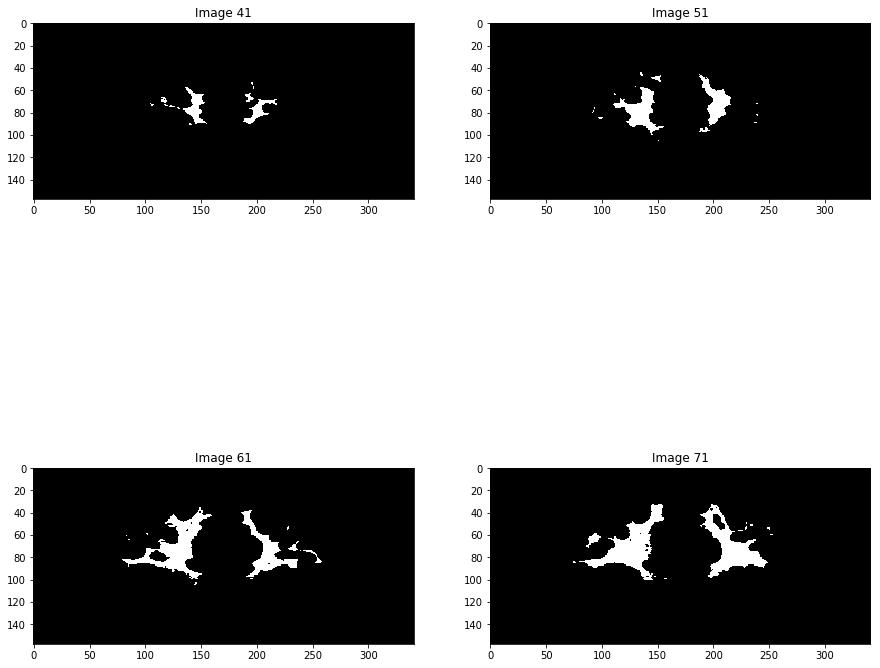

In [387]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
ax00 = axes[0, 0]
ax01 = axes[0, 1]
ax10 = axes[1, 0]
ax11 = axes[1, 1]
ax00.imshow(sitk.GetArrayFromImage(image[:,:,40]))
ax00.set_title("Image 41")
ax01.imshow(sitk.GetArrayFromImage(image[:,:,50]))
ax01.set_title("Image 51")
ax10.imshow(sitk.GetArrayFromImage(image[:,:,60]))
ax10.set_title("Image 61")
ax11.imshow(sitk.GetArrayFromImage(image[:,:,70]))
ax11.set_title("Image 71")
plt.show()

Para finalizar se guarda cada slice en un archivo distinto

In [309]:
from matplotlib import image as img
for i in range(size[2]):
    slice_i = sitk.GetArrayFromImage(image[:,:,i])
    out_fname = out_dir+dicom_names[i][dicom_names[i].rfind("/"):dicom_names[i].find(".")]+out_ext
    img.imsave(out_fname, slice_i)

El método propio de la librería SimpleITK para guardar la imagen, *WriteImage*,  imprime todas las imagenes en negro, por lo que se hace uso del metodo *imsave* de la librería *matplotlib*.

##### 1.2.3 Visualización mediante sitk.Show()

Se muestran las imágenes leídas mediante la orden **Show** que llama al programa **Fiji**. Por defecto dicho método exporta el archivo contenedor de las imágenes en un archivo secuencial de formato NII, la impresión en distintos formatos se logra con la modificación de la variable de entorno SITK_SHOW_EXTENSION, sin embargo, no ha aportado resultados satisfactorios al tratar de guardar los slices individualmente.

In [310]:
if (not "SITK_NOSHOW" in os.environ):
    sitk.Show(image, "Dicom Series")

Se debe repetir toda la secuencia de órdenes para cada serie de archivos Dicom, modificando adecuadamente las variables **input_dir** y **out_dir**

##### 1.2.4 Manejo de imágenes SimpleITK.

Una observación a tener en cuenta en la conversión entre imágenes SimpleITK.Image y Numpy.array es la diferente gestión de las dimensiones.

###### 1.2.4.1 - Imágenes DICOM

Analizando el proceso de generación de los archivos .png se observa como se han guardado imagenes bidimensionales y en escala de grises (pixeles escalares, no vectores). 

In [ ]:
print ("image dtype: \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\tnumber of components per pixel: {} \n\t pixel: {}".format(type(image), image.GetSize(), image.GetPixelIDTypeAsString(), image.GetNumberOfComponentsPerPixel(), image.GetPixel(0,0,0)))

slice_50 = image[:,:,49]
print ("slice_50 dtype: \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\tnumber of components per pixel: {} \n\t pixel: {}".format(type(slice_50), slice_50.GetSize(), slice_50.GetPixelIDTypeAsString(), slice_50.GetNumberOfComponentsPerPixel(), slice_50.GetPixel(0,0)))

slice_50_asarray = sitk.GetArrayFromImage(slice_50)
print ("slice_50_asarray \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\t pixel: {}".format(type(slice_50_asarray), slice_50_asarray.shape, slice_50_asarray.dtype, slice_50[0,0]))

A pesar de ello, cargar la imagen guardada en un fichero PNG genera la tercera dimensión con una longitud de 4 unidades.

Se lee un nuevo archivo DICOM correspondiente a aquel del que se ha obtenido el archivo PNG para comparar las lecturas de los distintos archivos

In [418]:
tocompare_dicom_fname = "datos/dicom"+input_fname[input_fname.find("png")+3:input_fname.find(".png")]+".dcm"
print ("Reading Dicom file: ", tocompare_dicom_fname)
reader = sitk.ImageFileReader()
reader.SetFileName(tocompare_dicom_fname)
dicom_image = reader.Execute()
print ("dicom_image \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\tnumber of components per pixel: {} \n\tpixel: ".format(type(dicom_image), dicom_image.GetSize(), dicom_image.GetPixelIDTypeAsString(), dicom_image.GetNumberOfComponentsPerPixel()))


Reading Dicom file:  datos/dicom/WM/IMG0050.dcm
dicom_image 
	dtype: <class 'SimpleITK.SimpleITK.Image'> 
	dshape: (341, 158, 1) 
	pixeldtype: 16-bit unsigned integer 
	number of components per pixel: 1 
	pixel: 


###### 1.2.4.2 - Imágenes PNG 

Para analizar este comportamiento vamos a cargar una imagen PNG de las recien generadas.

###### Mediante matplotlib


matplot_png_image 
	dtype: <type 'numpy.ndarray'> 
	dshape: (158, 341, 4) 
	pixeldtype: float32 
	 pixel: [ 0.  0.  0.  1.]


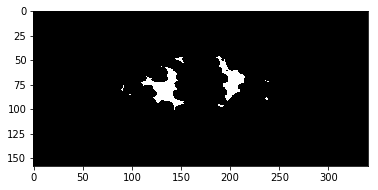

In [411]:
input_fname = "datos/png/WM/IMG0050.png"
matplot_png_image = plt.imread(input_fname)
print ("matplot_png_image \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\t pixel: {}".format(type(matplot_png_image), matplot_png_image.shape, matplot_png_image.dtype, matplot_png_image[0,0]))
plt.imshow(matplot_png_image)


###### Mediante SimpleITK

sitk_png_image 
	dtype: <class 'SimpleITK.SimpleITK.Image'> 
	dshape: (341, 158) 
	pixeldtype: vector of 8-bit unsigned integer 
	number of components per pixel: 4 
	pixel: (0, 0, 0, 255)


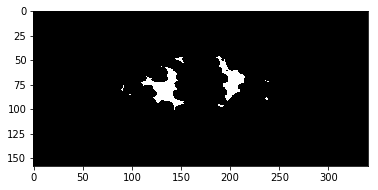

In [412]:
reader = sitk.ImageFileReader()
reader.SetFileName(input_fname)
sitk_png_image = reader.Execute()
print ("sitk_png_image \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\tnumber of components per pixel: {} \n\tpixel: {}".format(type(sitk_png_image), sitk_png_image.GetSize(), sitk_png_image.GetPixelIDTypeAsString(), sitk_png_image.GetNumberOfComponentsPerPixel(), sitk_png_image.GetPixel(0,0)))
plt.imshow(sitk.GetArrayFromImage(sitk_png_image))


La carga mediante matplotlib o mediante SimpleITK resulta en una imagen con la cuarta dimensión. Por lo que se descarta que la generación de la dimensión esté relacionada con la librería utilizada. Más apunta a ser consecuencia del guardado del fichero en el formato PNG.

In [413]:
sitk_png_image_asarray = sitk.GetArrayFromImage(sitk_png_image)
print ("sitk_png_image_asarray \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {}".format(type(sitk_png_image_asarray), sitk_png_image_asarray.shape, sitk_png_image_asarray.dtype))

sitk_png_image_asarray 
	dtype: <type 'numpy.ndarray'> 
	dshape: (158, 341, 4) 
	pixeldtype: uint8


Una imagen en escala de grises se puede representar con un numpy.array de 2 dimensones. 

Entonces, ¿cuales son el resto de valores de dicho vector?

In [414]:
print ("sitk_png_image \n\tpixel vector: ", sitk_png_image.GetPixel(0,0))
print ("sitk_png_image_asarray \n\tpixel vector: ", sitk_png_image_asarray[0,0])

sitk_png_image 
	pixel vector:  (0, 0, 0, 255)
sitk_png_image_asarray 
	pixel vector:  [  0   0   0 255]


No es casualidad que los tres primeros componentes del vector sean iguales. Son iguales a lo largo de toda la imagen. Es decir, al tratar imágenes en escala de grises, con tan solo un slice se tiene la imagen, el resto de información se completa para adecuarse al formato de PNG, pero no aporta información.

In [415]:
print (sitk_png_image_asarray[..., 0].all() == sitk_png_image_asarray[..., 1].all())
print (sitk_png_image_asarray[..., 0].all() == sitk_png_image_asarray[..., 2].all())

True
True


Lo mismo ocurre con los cargados mediante Matplotlib

In [435]:
print (matplot_png_image[..., 0].all() == matplot_png_image[..., 1].all())
print (matplot_png_image[..., 0].all() == matplot_png_image[..., 2].all())


True
True


In [436]:
dicom_image_asarray = sitk.GetArrayFromImage(dicom_image)
print ("dicom_image_asarray \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\t pixel: {}".format(type(dicom_image_asarray), dicom_image_asarray.shape, dicom_image_asarray.dtype, dicom_image_asarray[0,0]))
print ("sitk_png_image_asarray \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\t pixel: {}".format(type(sitk_png_image_asarray), sitk_png_image_asarray.shape, sitk_png_image_asarray.dtype, sitk_png_image_asarray[0,0]))

dicom_image_asarray 
	dtype: <type 'numpy.ndarray'> 
	dshape: (1, 158, 341) 
	pixeldtype: uint16 
	 pixel: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
sitk_png_image_asarray 
	dtype: <type 'numpy.ndarray'> 
	dshape: (158, 341, 4) 
	pixeldtype: uint8 
	 pixel: [  0   0   0 255]


Con esta comprobación se verifica como la generación de un vector de dimensión 4 en cada pixel es obra de la conversión a formato PNG.

A pesar de las dimensiones extras, las comparaciones entre ellas reportan ser similares.

In [441]:
print ("The slice previously loaded in the generation of the images match with the PNG loaded in the test (by SimpleITK):")
print (slice_50_asarray.all() == sitk_png_image_asarray[..., 0].all())
print (slice_50_asarray.all() == sitk_png_image_asarray.all())
print ("This doesn't match if the generation of the slicese has been done with other path.\n")

print ("The dicom recently loaded directly from DICOM file is equal as the PNG loaded file (by SimpleITK):")
print (dicom_image_asarray.all() == sitk_png_image_asarray[..., 0].all())
print (dicom_image_asarray.all() == sitk_png_image_asarray.all())

The slice previously loaded in the generation of the images match with the PNG loaded in the test (by SimpleITK):
True
True
This doesn't match if the generation of the slicese has been done with other path.

The dicom recently loaded directly from DICOM file is equal as the PNG loaded file (by SimpleITK):
True
True


In [440]:

print ("The slice previously loaded in the generation of the images match with the PNG loaded in the test (by Matplotlib):")
print (slice_50_asarray.all() == matplot_png_image[..., 0].all())
print (slice_50_asarray.all() == matplot_png_image.all())
print ("This doesn't match if the generation of the slicese has been done with other path.\n")

print ("The dicom recently loaded directly from DICOM file is equal as the PNG loaded file (by Matplotlib):")
print (dicom_image_asarray.all() == matplot_png_image[..., 0].all())
print (dicom_image_asarray.all() == matplot_png_image.all())


The slice previously loaded in the generation of the images match with the PNG loaded in the test (by Matplotlib):
True
True
This doesn't match if the generation of the slicese has been done with other path.

The dicom recently loaded directly from DICOM file is equal as the PNG loaded file (by Matplotlib):
True
True


Llegado a este punto, teniendo en cuenta las pruebas realizadas, se tiene la certeza de la correlación entre los dos formatos utilizados lo que aporta solidez para la confianza en los procesamientos que se hagan en las imágenes en adelante.

Se debe prestar atención a las orientaciones de las imágenes dado que las distintas transformaciones y manejo de distintos formatos modifican el orden de las dimensiones de la figura. 

#### 1.2.5 - Comprobación de imágenes binarias

Se verifica que las imágenes extraídas de los archivos I3TWM.hdr I3TGM.hdr e I3TCSF.hdr son binarias:

In [445]:
print ("slice_50_asarray:")
unique_image, counts_image = np.unique(slice_50_asarray, return_counts=True)
print ("unique elements count (slice_50_asarray): \n{}".format(np.asarray((unique_image, counts_image))))
print ("max element = {}".format(np.max(slice_50_asarray)))

print ("\nsitk_png_image_asarray:")
print ("sitk_png_image_asarray \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\t pixel: {}".format(type(sitk_png_image_asarray), sitk_png_image_asarray.shape, sitk_png_image_asarray.dtype, sitk_png_image_asarray[0,0]))
unique_image, counts_image = np.unique(sitk_png_image_asarray[...,0], return_counts=True)
print ("unique elements count (sitk_png_image_asarray): \n{}".format(np.asarray((unique_image, counts_image))))
print ("max element = {}".format(np.max(sitk_png_image_asarray)))



slice_50_asarray:
unique elements count (slice_50_asarray): 
[[    0     1]
 [52664  1214]]
max element = 1

sitk_png_image_asarray:
sitk_png_image_asarray 
	dtype: <type 'numpy.ndarray'> 
	dshape: (158, 341, 4) 
	pixeldtype: uint8 
	 pixel: [  0   0   0 255]
unique elements count (sitk_png_image_asarray): 
[[    0   255]
 [52664  1214]]
max element = 255

sitk_png_image_asarray_casted:
sitk_png_image_asarray_casted 
	dtype: <type 'numpy.ndarray'> 
	dshape: (158, 341, 4) 
	pixeldtype: uint16 
	 pixel: [  0   0   0 255]
unique elements count (image_asarray_casted): 
[[    0   255]
 [52664  1214]]
max element = 255


In [ ]:
rest = sitk.Subtract(sitk_png_image, )

In [ ]:
print ("\nsitk_png_image_asarray_casted:")
sitk_png_image_asarray_casted = sitk_png_image_asarray.astype(np.uint16)
print ("sitk_png_image_asarray_casted \n\tdtype: {} \n\tdshape: {} \n\tpixeldtype: {} \n\t pixel: {}".format(type(sitk_png_image_asarray_casted), sitk_png_image_asarray_casted.shape, sitk_png_image_asarray_casted.dtype, sitk_png_image_asarray_casted[0,0]))
unique_image, counts_image = np.unique(sitk_png_image_asarray_casted[...,0], return_counts=True)
print ("unique elements count (image_asarray_casted): \n{}".format(np.asarray((unique_image, counts_image))))
print ("max element = {}".format(np.max(sitk_png_image_asarray_casted)))

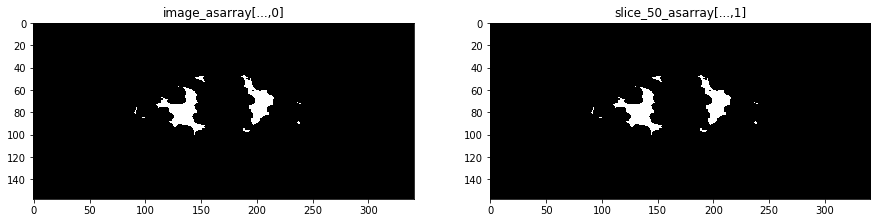

In [400]:
fig, axs = plt.subplots(1,2, figsize=(15,15))
ax0 = axs[0]
ax1 = axs[1]


ax0.imshow(sitk_png_image_asarray[...,2])
ax0.set_title("image_asarray[...,0]")

ax1.imshow(slice_50_asarray)
ax1.set_title("slice_50_asarray[...,1]")

plt.show()

El siguiente paso del problema se desarrolla en el notebook Procedimiento02.ipynb